# Building Good Training Sets - Data Preprocessing

The quality of the data and the amount of useful information that it contains are key factors that determine how well a machine learning algorithm can learn. Therefore, it is absolutely critical that we make sure of examine and preprocess a dataset before we feed it to a learning algorithm. In this chapter, we will discuss the essential data preprocessing techniques that will help us build good machine learning models. 

The topics what we will cover in this chapter are as follows:
* Removing and imputing missing values from the dataset
* Getting categorical data into shape for machine learning algorithms
* Selecting relevant features for the model construction

# Dealing with missing data

It is not uncommon in real-world applications for our samples to be missing one or more values for various reasons. There could have been an error in the data collection process, certain measurements are not applicable, or particular fields could have been simply left blank in a survey, for example. We typically see missing values as the blank spaces in our data table or as placeholder strings such as *NaN*, which stands for not a number, or *NULL* (a commonly used indicator of unknown values in relational databases). 

Unfortunately, most computational tools are unable to handle such missing values, or produce unpredictable results if we simply ignore them. Therefore, it is crucial that we take care of those missing values before we proceed with further analyses. In this section, we will work through several practical techniques for dealing with missing values by removing entries from our dataset or imputing missing values from other samples and features. 

# Identifying missing values in tabular data

But before we discuss several techniques for dealing with missing values, let's create a simple example data frame from a **Comma-separated Values (CSV)** file to get a better grasp of the problem: 

In [1]:
import pandas as pd
from io import StringIO

csv_data = \
'''A,B,C,D
1.0,2.0,3.0,4.0
5.0,6.0,,8.0
10.0,11.0,12.0,'''
df = pd.read_csv(StringIO(csv_data))
df

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,10.0,11.0,12.0,NaN


Using the preceding code, we read CSV-formatted data into a pandas *DataFrame* via the *read_csv* function and noticed that the two missing cells were replaced by *NaN*. The *StringIO* function in the preceding code example was simply used for the purposes of illustration. It allows us to read the string assigned to *csv_data* into a pandas *DataFrame* as if it was a regular CSV file on our hard drive. 

For a larger *DataFrame*, it can be tedious to look for missing values manually; in this case, we can use the *isnull* method to return a *DataFrame* with Boolean values that indicate whether a cell contains a numeric value (False) or if data is missing (True). Using the *sum* method, we can then return the number of missing values per column as follows:

In [2]:
df.isnull().sum()

A    0
B    0
C    1
D    1
dtype: int64

This way, we can count the number of missing values per column; in the following subsections, we will take a look at different strategies for how to deal with this missing data. 

Although scikit-learn was developed for working with NumPy arrays, it can sometimes be more convenient to preprocess data using pandas' *DataFrame*. We can always access the underlying NumPy array of a *DataFrame* via the *values* attribute before we feed it into a scikit-learn estimator: 

In [3]:
df.values

array([[ 1.,  2.,  3.,  4.],
       [ 5.,  6., nan,  8.],
       [10., 11., 12., nan]])

# Eliminating samples of features with missing values

One of the easiest ways to deal with missing data is to simply remove the corresponding features (columns) or samples (rows) from the dataset entirely; rows with missing values can be easily dropped via the *dropna* method:

In [4]:
df.dropna(axis=0)

,A,B,C,D
0,1.0,2.0,3.0,4.0


Similarly, we can drop columns that have at least one *NaN* in any row by setting the *axis* argument to *1*: 

In [5]:
df.dropna(axis=1)

,A,B
0,1.0,2.0
1,5.0,6.0
2,10.0,11.0


The *dropna* method supports several additional parameters that can come in handy:

In [6]:
# only drops rows where all columns are NaN
print(df.dropna(how='all'), '\n')

# drop rows that have less then 4 real values
print(df.dropna(thresh=4), '\n')

# only drop rows where NaN appear in specific columns
print(df.dropna(subset=['C']), '\n')

      A     B     C    D
0   1.0   2.0   3.0  4.0
1   5.0   6.0   NaN  8.0
2  10.0  11.0  12.0  NaN 

     A    B    C    D
0  1.0  2.0  3.0  4.0 

      A     B     C    D
0   1.0   2.0   3.0  4.0
2  10.0  11.0  12.0  NaN 



Although the removal of missing data seems to be a convenient approach, it also comes with certain disadvantages; for example, we may end up removing too many samples, which will make a reliable analysis impossible. Or, if we remove too many feature columns, we will run the risk of losing valuable information that our classifier needs to discriminate between classes. In the next section, we will thus look at one of the most commonly used alternatives for dealing with missing values: interpolation techniques. 

# Imputing missing values

Often, the removal of samples or dropping of entire feature columns is simply no feasible, because we might lose too much valuable data. In this case, we can use different interpolation techniques to estimate the missing values from the other training samples in our dataset. One of the most common interpolation techniques is **mean imputation**, where we simply replace the missing value with the mean value of the entire feature column. A convenient way to achieve this is by using the *Imputer* class from scikit-learn, as shown in the following code: 

In [7]:
from sklearn.preprocessing import Imputer

imr = Imputer(missing_values='NaN', strategy='mean', axis=0)
imr = imr.fit(df.values)
imputed_data = imr.transform(df.values)
imputed_data

array([[ 1. ,  2. ,  3. ,  4. ],
       [ 5. ,  6. ,  7.5,  8. ],
       [10. , 11. , 12. ,  6. ]])

Here, we replaced each *NaN* value with the corresponding mean, which is separately calculated for each feature column. If we changed the *axis=0* setting to *axis=1*, we would calculate the row means. Other options for the *strategy* prameter are *median* or *most_frequent*, where the latter replaces the missing values with the most frequent values. This is useful for imputing categorical feature values, for example, a feature column that stores an encoding of color names, such as red, green and blue, and we will encounter examples of such data later in this chapter. 

# Understanding the scikit-learn estimator API

In the previous section, we used the *Imputer* class from scikit-learn to impute missing values in our dataset. The *Imputer* class belongs to the so-called **transformer** classes in scikit-learn, which are used for data transformation. The two essential methods for those estimators are *fit* and *transform*. The *fit* method is used to learn the parameters from the training data, and the *transform* method uses those parameters to transform the data. Any data array that is transformed needs to have the same number of features as the data array that was used to fit the model. The following figure illustrates how a transformer, fitten on the training data, is used to transform a training dataset as well as a new test dataset: 

<img src='images/04_01.png'>

The classifiers that we used previously belong to the so-called **estimators** in scikit-learn with an API that is conceptually very similar to the transformer class. Estimators have a *predict* method but can also have a *transform* method, as we will see later in this chapter. 

As you may recall, we also used the *fit* method to learn the parameters of a model when we trained those estimators for classification. However, in supervised learning tasks, we additionally provide the class labels for fitting the model, which can then be used to make predictions about new data samples via the *predict* method, as illustrated in the following figure:

<img src='images/04_02.png'>

# Handling categorial data

So far, we have only been working with numerical values. However, it is not uncommon that real-world datasets contain one or more categorical feature columns. In this section, we will make use of simple yet effective examples to see how we deal with this type of data in numerical computing libraries. 

# Nominal and ordinal features

When we are talking about categorical data, we have to further distinguish between **nominal** and **ordinal** features. Ordinal features can be understood as categorical values that can be sorted or ordered. For example, t-shirt size would be an ordinal feature, because we can define an order XL > L > M. In contrast, nominal features do not imply any order and, to continue with the previous example, we could think of t-shirt color as a nominal feature since it typically does not make sense to say that, for example, red is larger than blue. 

## Creating a example dataset

Before we explore different techniques to handle such categorical data, let's create a new *DataFrame* to illustrate the problem: 

In [8]:
import pandas as pd

df = pd.DataFrame([
    ['green', 'M', 10.1, 'class1'], 
    ['red', 'L', 13.5, 'class2'], 
    ['blue', 'XL', 15.3, 'class1']])
df.columns = ['color', 'size', 'price', 'classlabel']
df

,color,size,price,classlabel
0,green,M,10.1,class1
1,red,L,13.5,class2
2,blue,XL,15.3,class1


As we can see in the preceding output, the newly created *DataFrame* contains a nominal feature (*color*), an ordinal feature (*size*), and a numerical feature (*price*) column. The class labels (assuming that we created a dataset for a supervised learning task) are stored in the last column. The learning algorithms for classification that we discuss in this book do not use ordinal information in class labels. 

## Mapping ordinal features

To make sure that the learning algorithm interprets the ordinal features correctly, we need to convert the categorical string values into integer. Unfortunately, there is no convenient function that can automatically derive the correct order of the labels of our *size* feature, so we have to define the mapping manually. In the following simple example, let's assume that we know the numerical difference between features, for example, $XL = L + 1 = M + 2$: 

In [9]:
size_mapping = {
    'XL': 3, 
    'L': 2, 
    'M': 1
}
df['size'] = df['size'].map(size_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,class1
1,red,2,13.5,class2
2,blue,3,15.3,class1


If we want to transform the integer values back to the original string representation at a later stage, we can simply define a reverse-mapping dictionary that can then be used via the pandas *map* method on the transformed feature column, similiar to the *size_mapping* dictionary that we used previously. We can use it as follows:

In [10]:
inv_size_mapping = {v: k for k, v in size_mapping.items()}
df['size'].map(inv_size_mapping)

0     M
1     L
2    XL
Name: size, dtype: object

## Encoding class labels

Many machine learning libraries require that class labels are encoded as integer values. Although most estimators for classification in scikit-learn convert class labels to integers internally, it is considered good practice to provide class labels as integer arrays to avoid technical glitches. To encode the class labels, we can use an approach similar to the mapping of ordinal features discussed previously. We need to remember that class labels are not ordinal, and it does not matter which integer number we assign to a particular string label. Thus, we can simply enumerate the class labels, starting at 0: 

In [11]:
import numpy as np

class_mapping = {label:idx for idx,label in 
                 enumerate(np.unique(df['classlabel']))}
class_mapping

{'class1': 0, 'class2': 1}

Next, we can use the mapping dictionary to transform the class labels into integers:

In [12]:
df['classlabel'] = df['classlabel'].map(class_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,0
1,red,2,13.5,1
2,blue,3,15.3,0


We can reverse the key-value pairs in the mapping dictionary as follows to map the converted class labels back to the original string representation: 

In [13]:
inv_class_mapping = {v:k for k,v in class_mapping.items()}
df['classlabel']= df['classlabel'].map(inv_class_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,class1
1,red,2,13.5,class2
2,blue,3,15.3,class1


Alternatively, there is a convenient *LabelEncoder* class directly implemented in scikit-learn to achieve this:

In [14]:
from sklearn.preprocessing import LabelEncoder

class_le = LabelEncoder()
y = class_le.fit_transform(df['classlabel'].values)
y

array([0, 1, 0])

Note that the *fit_transform* method is just a shortcut for calling *fit* and *transform* separately, and we can use the *inverse_transform* method to transform the integer class labels back to their original string representation:

In [15]:
class_le.inverse_transform(y)

/usr/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


array(['class1', 'class2', 'class1'], dtype=object)

## Performing one-hot encoding on nominal features

In the previous section, we used a simple dictionary-mapping approach to convert the ordinal *size* feature into integers. Since scikit-learn's estimators for classification treat class labels as categorical data that does not imply any order (nominal), we used the convenient *LabelEncoder* to encode the string labels into integers. It may appear that we could use a similar approach to transform the nominal *color* column of our dataset, as follows:

In [16]:
X = df[['color', 'size', 'price']].values
color_le = LabelEncoder()
X[:, 0] = color_le.fit_transform(X[:, 0])
X

array([[1, 1, 10.1],
       [2, 2, 13.5],
       [0, 3, 15.3]], dtype=object)

After executing the preceding code, the first column of the NumPy array *X* now holds the new *color* values, which are encoded as follows: 
* blue = 0
* green = 1
* red = 2

If we stop at this point and feed the array to our classifier, we will make one of the most common mistakes in dealing with categorical data. Can you spot the problem? Although the color values do not come in any particular order, a learning algorithm will now assume that *green* is larger than *blue*, and *red* is largen than *green*. Although this assumption is incorrect, the algorithm could still produce useful results. However, those results would not be optimal. 

A common workaround for this problem is to use a techinique called **one-hot encoding**. The idea behind this approach is to create a new dummy feature for each unique value in the nominal feature column. Here, we would convert the *color* feature into three new features: *blue*, *green* and *red*. Binary values can then be used to indicate the particular *color* of a sample; for example, a *blue* sample can be encoded as *blue=1,green=0,red=0*. To perform this transformation, we can use the *OneHotEncoder* that is implemented in the *scikit-learn.preprocessing* module:

In [17]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(categorical_features=[0])
ohe.fit_transform(X).toarray()

array([[ 0. ,  1. ,  0. ,  1. , 10.1],
       [ 0. ,  0. ,  1. ,  2. , 13.5],
       [ 1. ,  0. ,  0. ,  3. , 15.3]])

When we initialized the *OneHotEncoder*, we defined the column position of the variable that we want to transform via the *categorical_features* parameter (note that *color* is the first column in the feature matrix *X*). By default, the *OneHotEncoder* returns a sparse matrix when we use the *transform* method, and we converted the sparse matrix representation into a regular (dense) NumPy array for the purpose of visualization via the *toarray* method. Sparse matrices are a more efficient way of storing large dataset and one that is supported by many scikit-learn function, which is especially useful if an array contains a lot of zeros. To omit the *toarray* step, we could alternatively initialize the encoder as *OneHotEncoder(..., sparse=False)* to return a regular NumPy array. 

An even more convenient way to create those dummy features via one-hot encoding is to use the *get_dummies* method implemented in pandas. Applied to a *DataFrame*, the *get_dummies* method will only convert string columns and leave all other columns unchanged: 

In [18]:
pd.get_dummies(df[['price', 'color', 'size']])

,price,size,color_blue,color_green,color_red
0,10.1,1,0,1,0
1,13.5,2,0,0,1
2,15.3,3,1,0,0


When we are using one-hot encoding datasets, we have to keep in mind that it introduces multicollinearity, which can be an issue for certain methods (for instance, methods that require matrix inversion). If features are highly correlated, matrices are computationally difficult to invert, which can lead to numerically unstable estimates. To reduce the correlation among variables, we can simply remove one feature column from the one-hot encoded array. Note that we do not lose any important information by removing a feature column, though, for example, if we remove the column *color_blue*, the feature information is still preserved since if observe *color_green=0* and *color_red=0*, it implies that the observation must be *blue*. 

If we use the *get_dummies* function, we can drop the first column by passing *True* argument to the *drop_first* parameter, as shown in the following code example: 

In [19]:
pd.get_dummies(df[['price', 'color', 'size']], drop_first=True)

,price,size,color_green,color_red
0,10.1,1,1,0
1,13.5,2,0,1
2,15.3,3,0,0


The *OneHotEncoder* does not have a parameter for column removal, but we can simply slice the one-hot encoded NumPy array as shown in the following snippet: 

In [20]:
ohe = OneHotEncoder(categorical_features=[0])
ohe.fit_transform(X).toarray()[:, 1:]

array([[ 1. ,  0. ,  1. , 10.1],
       [ 0. ,  1. ,  2. , 13.5],
       [ 0. ,  0. ,  3. , 15.3]])

# Partitioning a dataset into separate training and test sets

We briefly introduced the concept of partitioning a dataset into separate datasets for training and testing. Remember that comparing predictions to true labels in the test set can be understood as the unbiased performance evaluation of our model before we let it loose on the real world. In this section, we will prepare a new dataset, the **Wine** dataset. After we have preprocessed the dataset, we will explore different techniques for feature selection to reduce the dimensionality of the dataset. The Wine dataset is another open-source dataset, it consists of 178 wine samples with 13 features describing their different chemical properties. 

Using the *pandas* library, we will directly read in the open source wine dataset from UCI machine learning repository:

In [21]:
import pandas as pd
import numpy as np

df_wine = pd.read_csv('https://archive.ics.uci.edu/'
                      'ml/machine-learning-databases/'
                      'wine/wine.data', header=None)
# To read from the local file
# df_wine = pd.read_csv('wine.data', header=None)

df_wine.columns = ['Class label', 'Alcohol', 
                   'Malic acid', 'Ash', 
                   'Alcalinity of ash', 'Magnesium', 
                   'Total phenols', 'Flavanoids', 
                   'Nonflavanoid phenols', 
                   'Proanthocyanins', 
                   'Color intensity', 'Hue', 
                   'OD280/OD315 of diluted wines', 
                   'Proline']
print('Class labels', np.unique(df_wine['Class label']))
df_wine.head()

Class labels [1 2 3]


,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


The samples belong to one of three different classes, 1, 2, and 3, which refer to the three different types of graph grown in the same region in Italy but derived from different wine cultivars, as described in the dataset summary. 

A convenient way to randomly partition this dataset into separate test and training datasets is to use the *train_test_split* function from scikit-learn's *model_selection* submodule: 

In [22]:
from sklearn.model_selection import train_test_split

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
X_train, X_test, y_train, y_test =\
    train_test_split(X, y, test_size=0.3, 
                     random_state=0, 
                     stratify=y)

First, we assigned the NumPy array representation of the feature columns 1-13 to the variable *X*; we assigned the class labels from the first column to the variable *y*. Then, we used the *train_test_split* function to randomly split *X* and *y* into separate training and test datasets. By setting *test_size=0.3*, we assigned 30 percent of the wine samples to *X_test* and *y_test*, and the remaining 70 percent of the samples were assigned to *X_train* and *y_train*, respectively. Proving the class label array *y* as an argument to *stratify* ensures that both training and test datasets have the same class proportions as the original dataset. 

If we are dividing a dataset into training and test datasets, we have to keep in mind that we are withholding valuable information that the learning algorithm could benefit from. Thus, we do not want to allocate too much information to the test set. However, the smaller the test set, the more inaccurate the estimation of the generalization error. Dividing a dataset into training and test sets is all about balancing this trade-off. In practice, the most commonly used splits are 60:40, 70:20, or 80:20, depending on the size of the initial dataset. However, for large datasets, 90:10 or 99:1 splits into training and test subsets are also common and appropriate. Instead of discarding the allocated test data after model training and evaluation, it is a common practice to retrain a classifier on the entire dataset as it can improve the predictive performance of the model. While this approach is generally recommended, it could lead to worse generalization performance if the dataset is small and the test set contains outliers, for example. Also, after refitting the model on the whole dataset, we do not have any independent data left to evaluate its performance. 

# Bringing features onto the same scale

**Feature scaling** is a crucial step in our preprocessing pipeline that can easily be forgotten. Decision trees and random forests are two of the very few machine learning algorithms where we do not need to worry about feature scaling. Those algorithms are scale invariant. However, the majority of machine learning and optimization algorithms behave much faster if features are on the same scale, as we have seen before when we implemented the **gradient descent** optimization algorithm. 

The importance of feature scaling can be illustrated by a simple example. Let's assume that we have two features where one feature is measured on a scale from 1 to 10 and the second feature is measured on a scale from 1 to 100000, respectively. When we think of the squared error function in Adaline, it is intuitive to say that the algorithm will mostly be busy optimizing the weights according to the larger errors in the second feature. Another example is the **k-nearest neighbors (KNN)** algorithm with a Euclidean distance measure; the computed distances between samples will be dominated by the second feature axis. 

Now, there are two common approaches to bring different features onto the same scale: **normalization** and **standardization**. Those terms are often used quite loosely in different fields, and the meaning has to be derived from the context. Most often, normalization refers to the rescaling of the features to a range of [0, 1], which is a special case of **min-max scaling**. To normalize our data, we can simply apply the min-max scaling to each feature column, where the new value $x^{(i)}_{norm}$ of a sample $x^{(i)}$ can be calculated as follows: 

$$x^{(i)}_{norm} = \frac{x^{(i)} - x_{min}}{x_{max} - x_{min}}$$

Here, $x^{(i)}$ is a particular sample, $x_{min}$ is the smallest value in the feature column, and $x_{max}$ the largest value. 

The min-max scaling procedure is implemented in scikit-learn and can be used as follows:

In [23]:
from sklearn.preprocessing import MinMaxScaler

mms = MinMaxScaler()
X_train_norm = mms.fit_transform(X_train)
X_test_norm = mms.transform(X_test)

Although normalization via min-max scaling is a commonly used technique that is useful when we need values in a bounded interval, stardardization can be more practical for many machine learning algorithms, especially for optimization algorithms such as gradient descent. The reason is that many linear models, such as the logistic regression and SVM, initialize the weights to 0 or small random values close to 0. Using standardization, we center the features columns at mean 0 with standard deviation 1 so that the feature columns takes the form of a normal distribution, which makes it easier to learn the weights. Furthermore, stardardization maintains useful information about outliers and makes the algorithm less sensitive to them in contrast to min-max scaling, which scales the data to a limited range of values.

The procedure for standardization can be expressed by the following equation:

$$x^{(i)}_{std} = \frac{x^{(i)} - \mu_x}{\sigma_x}$$

Here, $\mu_x$ is the sample mean of a particular feature column and $\sigma_x$ is the corresponding standard deviation. 

You can perform the standardization and normalization example by executing the following code examples:

In [24]:
ex = np.array([0, 1, 2, 3, 4, 5])
print('standardized:', (ex-ex.mean())/ex.std())
print('normalized:', (ex - ex.min())/(ex.max()-ex.min()))

standardized: [-1.46385011 -0.87831007 -0.29277002  0.29277002  0.87831007  1.46385011]
normalized: [0.  0.2 0.4 0.6 0.8 1. ]


Similar to the *MinMaxScaler* class, scikit-learn also implements a class for standardization:

In [25]:
from sklearn.preprocessing import StandardScaler

stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

Again, it is also important to highlight that we fit the *StandardScaler* class only once, on the training data, and use those parameters to transform the test set or any new data point. 

# Selecting meaningful features

If we notice that a model performs much better on a training dataset than on the test dataset, this observation is a strong indicator of **overfitting**. As we discussed before, overfitting means the models fits the parameters too closely with regard to the particular observations in the training dataset, but does not generalize well to new data, and we say the model has a *high variance*. The reason for the overfitting is that our model is too complex for the given training data. Common solutions to reduce the generalization error are listed as follows:
* Collect more training data
* Introduce a penalty for complexity via regularization
* Choose a simpler model with fewer parameters
* Reduce the dimensionaly of the data
Collecting more training data is often not applicable. Later we will learn about a useful technique to check whether more training data is helpful at all. In the following section, we will look at common ways to reduce overfitting by regularization and dimensionality reduction via feature selection, which leads to simpler models by requiring fewer parameters to be fitted to the data. 

## L1 and L2 regularization as penalties against model complexity

We recall that **L2 regularization** is one approach to reduce the complexity of a model by penalizing large individual weights, where we defined the L2 norm of our weight vector *w* as follows:

$$L2: ||w||^2_2 = \sum^{m}_{j=1}w^2_j$$

Another approach to reduce the model complexity is the related **L1 regularization**:

$$L1: ||w||_1 = \sum^{m}_{j=1}|w_j|$$

Here, we simply replaced the square of the weights by the sum of the absolute values of the weights. In contrast to L2 regularization, L1 regularization usually yields sparse feature vector; most features weights will be zero. Sparsity can be useful in practice if we have a high-dimensional dataset with many features that are irrelevant, especially cases where we have more irrelevant dimensions than samples. In this sense, L1 regularization can be understood as a technique for feature selection. 

## A geometric interpretation of L2 regularization

As mentioned in the previous section, L2 regularization adds a penalty term to the cost function that effectively results in less extreme weigh values compared to a model trained with an unregularized cost function. To better understand how L1 regularization encourages sparsity, let's take a step back and take a look at a geometric interpretation of regularization. Let us plot the contours of a convex cost function for two weight coefficients, $w_1$ and $w_2$. Here, we will consider the **Sum of Squared Errors (SSE)** cost function that we used for Adaline, since it is spherical and easier to draw than the cost function of logistic regression; however, the same concepts apply to the latter. Remember that our goal is to find the combination of weight coefficients that minimize the cost function for the training data, as shown in the following figure (the point in the center of the ellipses): 

<img src='images/04_04.png'>

Now, we can think of regularization as adding a penalty term to the cost function to encourage smaller weights; or in other words, we penalize large weights. 

Thus, by increasing the regularization strength via the regularization parameter $\lambda$, we shrink the weights towards zero and decrease the dependence of our model on the training data. Let us illustrate this concept in the following figure for the L2 penalty term:

<img src='images/04_05.png'>

The quadratic L2 regularization term is represented by the shaded ball. Here, our weight coefficients cannot exceed our regularization budget; the combination of the weight coefficients cannot fall outside the shaded area. On the other hand, we still want to minimize the cost function. Under the penalty constraint, our best effort is to choose the point where the L2 ball intersects with the contours of the unpenalized cost function. The larger the value of the regularization $\lambda$ gets, the faster the penalized cost grows, which leads to a narrower L2 ball. For example, if we increase the regularization parameter towards infinity, the weight coefficients will become effectively zero, denoted by the center of the L2 ball. To summarize the main message of the example, our goal is to minimize the sum of the unpenalized cost plus the penalty term, which can be understood as adding bias and preferring a simpler model to reduce the variance in the absence of sufficient training data to fit the model. 

## Sparse solutions with L1 regularization

Now, let us discuss L1 regularization and sparsity. The main concept behind L1 regularization is similar to what we have discussed in the previous section. However, since the L1 penalty is the sum of the absolute weight coefficients (remember that the L2 term is quadratic), we can represent it as a diamond-shape budget, as shown in the following figure: 

<img src='images/04_06.png'>

In the preceding figure, we can see that the contour of the cost function touches the L1 diamond at $w_1=0$. Since the contours of an L1 regularized system are sharp, it is more likely that the optimum; that is, the intersection between the ellipses of the cost function and the boundary of the L1 diamond, is located on the axes, which encourages sparsity. 

For regularized models in scikit-learn that support L1 regularization, we can simply set the *penalty* parameter to *'l1'* to obtain a sparse solution:

In [26]:
from sklearn.linear_model import LogisticRegression

LogisticRegression(penalty='l1')

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Applied to the standardized Wine data, the L1 regularized logistic regression would yield the following sparse solution:

In [27]:
lr = LogisticRegression(penalty='l1', C=1.0)
lr.fit(X_train_std, y_train)
print('Training accuracy:', lr.score(X_train_std, y_train))
print('Test accuracy:', lr.score(X_test_std, y_test))

Training accuracy: 1.0
Test accuracy: 1.0


Both training and test accuracies (both 100 percent) indicate that our model does a perfect job on both datasets. When we access the intercept terms via the *lr.intercept_* attribute, we can see that the array returns these values:

In [28]:
lr.intercept_

array([-1.26345948, -1.21637638, -2.37039433])

Since, we fit the *LogisticRegression* object on a multiclass dataset, it uses the **One-versus-Rest (OvR)** approach by default, where the first intercept belongs to the model that fits class 1 versus class and 3, the second value is the intercept of the model that fits class 2 versus class 1 and 3, and the third value is the intercept of the model that fits class 3 versus class 1 and 2:

In [29]:
lr.coef_

array([[ 1.24560149,  0.18083923,  0.74356908, -1.16123559,  0.        ,
         0.        ,  1.16996853,  0.        ,  0.        ,  0.        ,
         0.        ,  0.54700546,  2.51062974],
       [-1.5373154 , -0.38690538, -0.99465785,  0.36398878, -0.05964683,
         0.        ,  0.66766912,  0.        ,  0.        , -1.93424417,
         1.23440971,  0.        , -2.23195484],
       [ 0.13574068,  0.16844252,  0.35727549,  0.        ,  0.        ,
         0.        , -2.43803574,  0.        ,  0.        ,  1.56372255,
        -0.81879496, -0.49238285,  0.        ]])

The weight array that we accessed via the *lr.coef_* attribute contains three rows of weight coefficients, one weight vector for each class. Each row consists of 13 weights where each weight is multiplied by the respective feature in the 13-dimensional Wine dataset to calculate the net input. 

As a result of L1 regularization, which serves as a method for feature selection, we just trained a model that is robust to the potentially irrelevant feature in this dataset. 

Stricly speaking, the weight vectors from the previous example are not necessarily sparse, though, because they contain more non-zero than zero entries. However, we could enforce sparsity (more zero entries) by further increasing the regularization strength, that is, choosing lower values for the *C* parameter. 

In the last example on regularization in this chapter, we will vary the regularization strength and plot the regularization path; the weight coefficients of the different features for different regularization strengths:

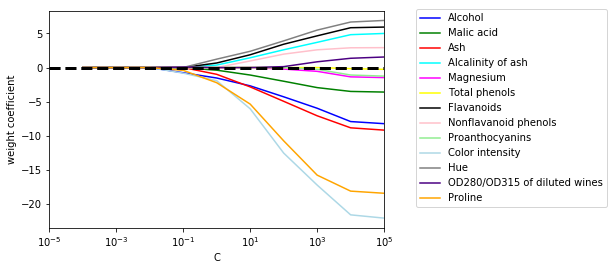

In [30]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.subplot(111)

colors = ['blue', 'green', 'red', 'cyan', 
          'magenta', 'yellow', 'black', 
          'pink', 'lightgreen', 'lightblue', 
          'gray', 'indigo', 'orange']

weights, params = [], []
for c in np.arange(-4.0, 6.0):
    lr = LogisticRegression(penalty='l1', C=10.**c, 
                            random_state=0)
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[1])
    params.append(10**c)
    
weights = np.array(weights)

for column, color in zip(range(weights.shape[1]), colors):
    plt.plot(params, weights[:, column], 
             label=df_wine.columns[column+1], 
             color=color)
plt.axhline(0, color='black', linestyle='--', linewidth=3)
plt.xlim([10**-5, 10**5])
plt.ylabel('weight coefficient')
plt.xlabel('C')
plt.xscale('log')
plt.legend(loc='upper left')
ax.legend(loc='upper center', 
          bbox_to_anchor=(1.38, 1.03), 
          ncol=1, fancybox=True)
plt.show()

The resulting plot provide us with further insights into the behavior of L1 regularization. As we can see, all feature weights will be zero if we penalize the model with strong regularization parameter ($C < 0.1$); *C* is the inverse of the regularization parameter $\lambda$. 

## Sequential feature selection algorithms

An alternative way to reduce the complexity of the model and avoid overfitting is **dimensionality reduction** via feature selection, which is especially useful for unregularized models. There are two main categories of dimensionality reduction techniques: **feature selection** and **feature extraction**. Via feature selection, we select a subset of the original features, whereas in feature extraction, we derive information from the feature set and construct a new feature subspace. 

Sequential feature selection algorithms are a family of greedy search algorithms that are used to reduce an initial *d*-dimensional feature space to a *k*-dimensional feature subspace where $k<d$. The motivation behind feature selection algorithms is to automatically select a subset of features that are most relevant to the problem, to improve computational efficiency or reduce the generalization error of the model by removing irrelevant features or noise, which can be useful for algorithms that do not support regularization. 

A classic sequential feature selection algorithm is **Sequential Backward Selection (SBS)**, which aims to reduce the dimensionality of the initial feature subspace with a minimum decay in performance of the classifier to improve upon computational efficiency. In certain cases, SBS can even improve the predictive power of the model if a model suffers from overfitting. 

The idea behind the SBS algorithm is quite simple: SBS sequentially removes features from the full feature subset until the new feature subspace contains the desired number of features. In order to determine which feature is to be removed at each stage, we need to define the criterion function $J$ that we want to minimize. The criterion calculated by the criterion function can simply be the difference in performance of the classifier before and after the removal of a particular feature. Then, the feature to be removed at each stage can simply be defined as the feature that maximizes the criterion; or in more intuitive terms, at each stage we eliminate the feature that causes the least performance loss after removal. Based on the preceding definition of SBS, we can outline the algorithm in four simple steps: 
1. Initialize the algorithm with $k=d$, where d is the dimensionality of the full feature space $X_d$. 
2. Determine the feature $x^-$ that maximizes the criterion: $x^- = \text{arg max} J(X_k - x)$, where $X \in X_k$. 
3. Remove the feature $x$ from the feature set: $X_{k-1} = X_k = x^-; k = k - 1$. 
4. Terminate if $k$ equals the number of desired features; otherwise, go to step 2. 



Unfortunately, the SBS algorithm has not been implemented in scikit-learn yet. But since it is so simple, let us go ahead and implement it in Python from scratch:

In [37]:
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

class SBS():
    def __init__(self, estimator, k_features, 
                 scoring=accuracy_score, test_size=0.25, 
                 random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state
        
    def fit(self, X, y):
        
        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=self.test_size, 
                             random_state=self.random_state)
        
        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, 
                                 X_test, y_test, 
                                 self.indices_)
        self.scores_ = [score]
        
        while dim > self.k_features:
            scores = []
            subsets = []
            
            for p in combinations(self.indices_, r=dim-1):
                score = self._calc_score(X_train, y_train, 
                                         X_test, y_test, p)
                scores.append(score)
                subsets.append(p)
                
            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1
            
            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]
        
        return self
    
    def transform(self, X):
        return X[:, self.indices_]
    
    def _calc_score(self, X_train, y_train, X_test, y_test, 
                    indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

In the preceding implementation, we defined the *k_features* parameter to specify the desired number of features we want to return. By default, we use the *accuracy_score* from scikit-learn to evaluate the performance of a model (an estimator for classification) on the feature subsets. Inside the *while* loop of the fit method, the feature subsets created by the *itertools.combination* function are evaluated and reduced until the feature subset has the desired dimensionality. In each iteration, the accuracy score of the best subset is collected in a list, *self.scores_*, based on the internally created test dataset *X_test*. We will use those scores later to evaluate the results. The column indices of the final feature subset are assigned to *self.indices_*, which we can use via the *transform* method to return a new data array with the selected feaure columns. Note that, instead of calculating the criterion explicity inside the *fit* method, we simply removed the feature that is not contained in the best performing feature subset. 

Now, let us see our SBS implementation in action using the KNN classifier from scikit-learn: 

In [38]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)

sbs = SBS(knn, k_features=1)
sbs.fit(X_train_std, y_train)

Although our SBS implementation already splits the dataset into a test and training dataset inside the *fit* function, we still fed the training dataset *X_train* to the algorithm. The SBS *fit* method will then create new training subsets for testing (validation) and training, which is why this test set is also called the **validation dataset**. This approach is necessary to prevent our *original* test set from becoming part of the training data. 

Remember that our SBS algorithm collects the scores of the best feature subset at each stage, so let us move on to the more exciting part of our implementation and plot the classification accuracy of the KNN classifier that was calculated on the validation dataset. The code is as follows: 

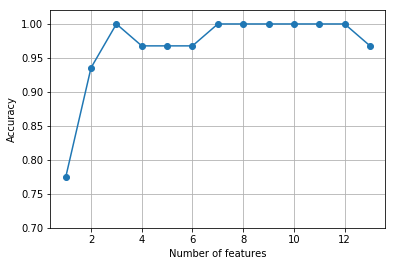

In [39]:
k_feat = [len(k) for k in sbs.subsets_]

plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.7, 1.02])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.show()

As we can see in the preceding figure, the accuracy of the KNN classifier improved on the validation dataset as we reduced the number of features, which is likely due to a decrease of the **curse of dimensionality** that we discussed in the context of the KNN algorithms. Also, we can see in the preceding plot that the classifier achieved 100 percent accuracy for $k={3, 7, 8, 9, 10, 11, 12}$. 

To satisfy our own curiosity, let's see what the smallest feature subset ($k=3$) that yielded such a good performance on the validation dataset looks like: 

In [40]:
k3 = list(sbs.subsets_[10])
print(df_wine.columns[1:][k3])

Index(['Alcohol', 'Malic acid', 'OD280/OD315 of diluted wines'], dtype='object')


Using the preceding code, we obtained the column indices of the tree-feature subset from the 10th position in the *sbs.subsets_* attribute and returned the corresponding feature names from the column-index of the pandas Wine *DataFrame*. 

Next let's evaluate the performance of the KNN classifier on the original test set:

In [41]:
knn.fit(X_train_std, y_train)
print('Training accuracy:', knn.score(X_train_std, y_train))
print('Test accuracy:', knn.score(X_test_std, y_test))

Training accuracy: 0.967741935483871
Test accuracy: 0.9629629629629629


In the preceding code section, we used the complete feature set and obtained approximately 97 percent accuracy on the training dataset and approximately 96 percent accuracy on the test, which indicates that our model already generalizes well to new data. Now, let us see the selected three-feature subset and see how well KNN performs:

In [42]:
knn.fit(X_train_std[:, k3], y_train)
print('Training accuracy:', knn.score(X_train_std[:, k3], y_train))
print('Test accuracy:', knn.score(X_test_std[:, k3], y_test))

Training accuracy: 0.9516129032258065
Test accuracy: 0.9259259259259259


Using less than a quarter of the original features in the Wine dataset, the prediction accuracy on the test declined slightly. This may indicate that those three features do not provide less discriminatory information than the original dataset. However, we also have to keep in mind that the Wine dataset is a small dataset, which is very susceptible to randomness; that is, the way we split the dataset into training and test subsets, and how we split the training dataset further into a training and validation subset. 

While we did not increase the performance of the KNN model by reducing the number of features, we shrank the size of the dataset, which can be useful in real-world applications that may involve expensive data collection steps. Also, by substantially reducing the number of features, we obtain simpler models, which are easier to interpret. 

**Feature selection algorithms in scikit-learn**

There are many more feature selection algorithms available via scikit-learn. Those include **recursive backward elimination** based on feature weights, tree-based methods to select features by importance, and univariate statistical tests.

## Assessing feature importance with random forests

In previous chapter, you learned how to use L1 regularization to zero out irrelevant features via logistic regression, and use the SBS algorithm for feature selection and apply it to a KNN algorithm. Another useful approach to select relevant features from a dataset is to use a **random forest**, an ensemble technique. Using a random forest, we can measure the feature importance as the averaged impurity decrease computed from all decision trees in the forest, without making any assumptions about whether our data is linearly separable or not. Conveniently, the random forest implementation in scikit-learn already collects the feature importance values for us so that we can access them via the *feature_importances_* attribute after fitting a *RandomForestClassifier*. By executing the following code, we will now train a forest of 10000 three on the Wine dataset and rank the 13 features by their respective importance measures, remember that we do not need to use stardardized or normalized features in tree-based models: 

 1) Proline                        0.185453
 2) Flavanoids                     0.174751
 3) Color intensity                0.143920
 4) OD280/OD315 of diluted wines   0.136162
 5) Alcohol                        0.118529
 6) Hue                            0.058739
 7) Total phenols                  0.050872
 8) Magnesium                      0.031357
 9) Malic acid                     0.025648
10) Proanthocyanins                0.025570
11) Alcalinity of ash              0.022366
12) Nonflavanoid phenols           0.013354
13) Ash                            0.013279


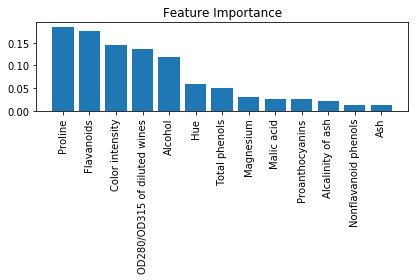

In [49]:
from sklearn.ensemble import RandomForestClassifier

feat_labels = df_wine.columns[1:]

forest = RandomForestClassifier(n_estimators=500, 
                                random_state=1)
forest.fit(X_train, y_train)
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print('%2d) %-*s %f' % (f+1, 30, feat_labels[indices[f]], 
                            importances[indices[f]]))
plt.title('Feature Importance')

plt.bar(range(X_train.shape[1]), 
        importances[indices], align='center')
plt.xticks(range(X_train.shape[1]), 
           feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

After executing the code, we created a plot that ranks the different features in the Wine dataset, by their relative importance; note that the feature importance values are normalized so that they sum up to 1.0.

We can conclude that the proline and flavanoid levels, the color intensity, the OD280/OD315 diffraction, and the alcohol concentration are the most discriminative features in the dataset based on the average impurity decrease in the 500 decision trees, Interestingly, two of the top-ranked features in the plot are also in the tree-feature subset selection from the SBS algorithm that we implemented in the previous section (alcohol concentration and OD280/OD315 of diluted wines). However, as far as interpretability is concerned, the random forest technique comes with an important *gotcha* that is worth mentioning. If two or more features are highly correlated, one feature may be ranked very highly while the information of the other features(s) may not be fully captured. On the other hand, we do not need to be concerned about this problem if we are merely interested in the predictive performance of a model rather than the interpretation of feature importance values. 

To conclude this section about feature importance values and random forests, it is worth mentioning that scikit-learn also implements a *SelectFromModel* object that selects features based on a user-specified threshold after model fitting, which is useful if we want to use the *RandomForestClassifier* as a feature selector and intermediate step in a scikit-learn *Pipeline* object, which allows us to connect different preprocessing steps with an estimator. For example, we could set the *threshold* to 0.1 to reduce the dataset to five most important features using the following code:

In [50]:
from sklearn.feature_selection import SelectFromModel

sfm = SelectFromModel(forest, threshold=0.1, prefit=True)
X_selected = sfm.transform(X_train)
print('Number of samples that meet this criterion:', X_selected.shape[0])
for f in range(X_selected.shape[1]):
    print('%2d) %-*s %f' % (f+1, 30, feat_labels[indices[f]], 
                            importances[indices[f]]))

Number of samples that meet this criterion: 124
 1) Proline                        0.185453
 2) Flavanoids                     0.174751
 3) Color intensity                0.143920
 4) OD280/OD315 of diluted wines   0.136162
 5) Alcohol                        0.118529


# Summary

We started this chapter by looking at useful techniques to make sure that we handle missing data correctly. Before we feed data to a machine learning algorithm, we also have to make sure that we encode categorical variables correctly, and we have seen how we can map ordinal and nominal feature values to integer representations. 

Moveover, we briefly discussed L1 regularization, which can help us to avoid overfitting by reducing the complexity of a model. As an alternative approach to removing irrelevant features, we used a sequential feature selection algorithm to select meaning features from the dataset. 

In the next chapter, you will learn about yet another useful approach to dimensionality reduction: feature extraction. It allows us to compress features onto a lower-dimensional subpace; rather than removing features entirely as in feature selection. 